<a href="https://colab.research.google.com/github/nerumur/Valeria_ML/blob/main/hw_1_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание 1

**Titanic challenge** - самое известное соревнование по Data Science

Используйте данные о пассажирах Титаника, чтобы построить свой классификатор, который предсказывает вероятность гибели пассажира на печально известном корабле

#### Шаг 1: импорт библиотек

In [ ]:
# каждая из этих библиотек использует свои сокращения
import pandas as pd                           # обработка и анализ данных
import numpy as np                            # операции с числами
import seaborn as sns                         # создание статистических графиков
import matplotlib.pyplot as plt               # визуализация данных

# далее мы импортируем миллион методов из scikit-learn (машинное обучение)
# эта часть уже выполнена, ура!

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Шаг 2: загружаем данные с Титаника

In [ ]:
# выгрузим датасет напрямую с URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# выведите первые 5 строк датасета
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Шаг 3: анализ данных

**1. выведите df.info()**
  - в каких столбцах есть NaN'ы?

  Age, Cabin и Embarked

  - ориентируясь на количество NaN'ов в столбцах, определите, какие строки "не жалко" выбросить, а какие лучше сохранить.
  
  Можем выбросить строки Cabin (мало ненулевых значений), Ticket (уник. номер билета), PassengerId (уник. номер пассажира) и Name; для анализа не важны.

**2. визуализируйте распределение классов по столбцу `Survived`**
  - сбалансировали ли классы в нашем датасете?

  Классы не сбалансированы. Выживших меньше, чем умерших

**3. выведите список столбцов, в которых представлены категориальные данные**
  - почему категориальные данные нужно будет обработать перед запуском обучения модели?

  Модели работают только с числами, поэтому категориальные данные необходимо преобразовать в числовой формат, чтобы модели могли их интерпретировать.


In [ ]:
#1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


df.info() показывает:
- Общее количество столбцов и строк
- Индекс колонок и их названия
- Количество ненулевых значений в каждом столбце
- Тип данных каждого столбца
- Общее количество использованной памяти

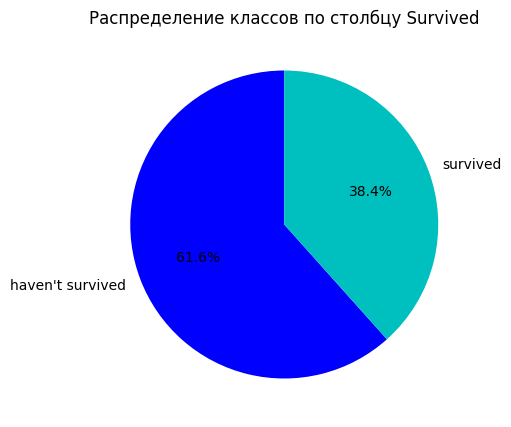

In [ ]:
# 2
data = df['Survived'].value_counts()                 # подсчет количества значений (1 и 0) в столбце
labels = ['haven\'t survived', 'survived']           # задаем список меток
fig = plt.figure(figsize=(5, 5))
plt.title('Распределение классов по столбцу Survived')
plt.pie(data, labels=labels, colors=['b', 'c'], autopct='%1.1f%%', startangle=90)
# startangle поворачивает диаграмму, делает более читаемой
# autopict создает числовые подписи + добавляет процентное значение

plt.show()

In [ ]:
#3
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Столбцы с категориальными данными:", cat_columns)

# Категориальные данные - признаки, которые выражены ограниченным диапазоном значений, не имеющие количественного выражения.

Столбцы с категориальными данными: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


#### Шаг 4: анализ данных

Ответы на эти вопросы помогут вам принять решения для препроцессинга данных:

- требуется ли балансировка классов? - нет, дисбаланс умеренный, пробуем без балансировки
- какие столбцы нужно дропнуть?
- какие данные нужно преобразовать к виду числовых?

**Дропаем столбцы**

Оставим классы в покое и сразу перейдем к очистке таблицы

Есть два пути:

- дропнуть "лишние" столбцы из исходной таблицы
- создать новую таблицу, в которую мы занесем только "нужные" столбцы

Выберите любой способ и создайте новый датафрейм, очищенный от неинформативных столбцов, в которых много NaN'ов

In [ ]:
df_1 = df.drop(['Name', 'Cabin', 'PassengerId', 'Ticket'], axis=1) # axis - удаление столбцов, а не строк
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


**Categorical --> Numerical**

Для преобразования категориальных данных к виду чисел, в sklearn используется метод `LabelEncoder`

- документация [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

Метод автоматически заменяет категориальные метки на целые числа

In [ ]:
# образец кодирования столбца 'Sex' с LabelEncoder
df_1['Sex'] = LabelEncoder().fit_transform(df_1['Sex'])  # 0 = female, 1 = male
df_1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


Рассмотрим еще один метод: мы имитируем one-hot encoding с помощью метода `get_dummies` из Pandas

- [документация метода](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

Принцип работы one-hot-encoding:

- как мы закодируем цифры 1 и 9, чтобы получить разреженный массив?
- создаем матрицу из двух векторов размерностью 10
  ```
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] # цифра 1
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] # цифра 9
  ```
- единица означает позицию цифры в ряде `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
- также:
  - единица означает `True` (число находится в этой позиции)
  - ноль означает `False` (число не находится в этой позиции)

При использовании этого метода в датафреймах, мы также создаем три новых столбца (три новых вектора), в которых помечаем `True` соответствие данной метке

In [ ]:
# образец кодирования столбца 'Embarked' с get_dummies
# в Embarked у нас три метки: C, Q, S (станция посадки пассажира)
df_1 = pd.get_dummies(df_1, columns=['Embarked'])  # one-hot encoding
df_1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,False,True
1,1,1,0,38.0,1,0,71.2833,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,True


Чем `LabelEncoder` отличается от `get_dummies` и когда какой метод лучше использовать?

`LabelEncoder` -> У данных есть порядок + когда много категорий

`get_dummies` -> Для категорий без порядка ("красный", "синий", "зеленый") + избегаем ложные связи между категориями + если категорий не так много (иначе насоздает кучу таблиц и займет больше памяти)

**Заполняем пропуски**

Мы убрали лишние столбцы, но NaN'ы по-прежнему есть в нашем датафрейме

Рассмотрим метод `SimpleImputer` из sklearn для заполнения пропусков в данных

- [документация SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [ ]:
# заполняем пропуски в столбце Age
imputer = SimpleImputer(strategy="mean")
df_1['Age'] = imputer.fit_transform(df_1[['Age']])
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked_C  891 non-null    bool   
 8   Embarked_Q  891 non-null    bool   
 9   Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 51.5 KB


Изучите документацию sklearn и ответьте на вопросы: какие стратегии доступы для работы с методом SimpleImputer? Чем они отличаются? Какие стратегии подойдут для работы с категориальными данными?

**Стратегии:**

'mean' (числа ) - наны заполняются средним значением по столбцу

'median' (числа) - наны заполняются медианой (число по центру) по столбцу

'most_frequent' (числа + строки) - наны заполняются наиболее часто встречающимся значением в столбце

'constant' (числа + строки) - наны заполняются заданным пользователем значением

Какие стратегии подойдут для работы с категориальными данными? - 'most_frequent' и 'constant'

**Feature Engineering**

> Данные - это пища для вашей модели

Слишком шумные данные вызовут отравление модели (кстати, один из методов киберпреступности, построенный на работе с данными, так и называется - data poisoning!)

Недостаточность в данных может стать причиной недообучения (underfitting), поэтому мы можем не только дропать, но и добавлять фичи, т.е. признаки, на которых будет учиться наша модель

Этот процесс называется **feature engineering**

In [ ]:
# Добавим фичу Family size = SibSp + Parch + 1 (единица обозначает самого пассажира)
df_1['FamilySize'] = df_1['SibSp'] + df_1['Parch'] + 1

# Фича Alone для тех, кто путешествует один
df_1['IsAlone'] = (df_1['FamilySize'] == 1).astype(int)

df_1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0,3,1,22.0,1,0,7.2500,False,False,True,2,0
1,1,1,0,38.0,1,0,71.2833,True,False,False,2,0
2,1,3,0,26.0,0,0,7.9250,False,False,True,1,1
3,1,1,0,35.0,1,0,53.1000,False,False,True,2,0
4,0,3,1,35.0,0,0,8.0500,False,False,True,1,1


Добавьте любую новую фичу в датафрейм, которая легко выводится из данных

Например, можно вытащить обращения к пассажирам из столбца `Name` из исходной таблицы: `Mr., Mrs., Dr.`

Для этого изучите внимательно данные, познакомьтесь с описанием датасета на Kaggle

- https://www.kaggle.com/c/titanic/

Вам нужно самостоятельно решить, что можно извлечь из этих данных, как назвать новую фичу и избавиться от категориальных меток

In [ ]:
# я решила добавить фичу, которая показывает, является ли пассажир частью большой семьи
df_1['BigFamily'] = (df_1['FamilySize'] >= 4).astype(int)  # astype преобразует в числа, true = 1, false = 0
df_1.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone,BigFamily
0,0,3,1,22.000000,1,0,7.2500,False,False,True,2,0,0
1,1,1,0,38.000000,1,0,71.2833,True,False,False,2,0,0
2,1,3,0,26.000000,0,0,7.9250,False,False,True,1,1,0
3,1,1,0,35.000000,1,0,53.1000,False,False,True,2,0,0
4,0,3,1,35.000000,0,0,8.0500,False,False,True,1,1,0
5,0,3,1,29.699118,0,0,8.4583,False,True,False,1,1,0
6,0,1,1,54.000000,0,0,51.8625,False,False,True,1,1,0
7,0,3,1,2.000000,3,1,21.0750,False,False,True,5,0,1
8,1,3,0,27.000000,0,2,11.1333,False,False,True,3,0,0
9,1,2,0,14.000000,1,0,30.0708,True,False,False,2,0,0


#### Шаг 4: обучение

Создаем пары `data - label`

In [ ]:
# бинарная логистическая регрессия
X = df_1.drop(columns=['Survived']) # данные = все столбцы кроме метки Survived
y = df_1['Survived'] # метки = только столбец Survived (прогнозируемая переменная)

Вспомните прошлое занятие: примените метод `train_test_split`

Создайте 2 выборки данных в соотношении 80 на 20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

Изучите информацию о том, как работает логистическая регрессия и ответьте на вопрос: какую роль играет `StandardScaler` в работе с логистической регрессией?

У разных данных - разный диапазон значений -> надо стандартизировать, привести к одному масштабу.

`StandardScaler` - класс, который используется для нормализации данных, он масштабирует данные таким образом, что они имеют среднее значение 0 и стандартное отклонение 1.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение, как и в случае работы с линейной регрессией, займет всего пару строк

Опишите основной принцип работы логистической регрессии своими словами (2-3 предложения достаточно)

Предварительно изучите материал: https://web.stanford.edu/~jurafsky/slp3/5.pdf

`Логистическая регрессия` - алгоритм классификации МЛ с учителем (-> нужны размеченные данные), предсказывает вероятность принадлежности объекта к определенному классу -> на выходе получаем число от 0 до 1. Если вероятность превышает заданный порог (обычно 0.5), объект относят к одному классу, иначе — к другому. Использует сигмоидную функцию.

Нам нужны `Х` - независимые переменные, используемые для предсказания. А также `Y` - прогнозируемая переменная (принимает бинарные значения).

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# предсказания
y_pred_log = log_reg.predict(X_test_scaled)

# вывод репорта
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Performance:
Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Повторим магию и обучим наивные байесовский классификатор. Что значит `Gaussian` в названии метода `GaussianNB`? Изучите документацию метода, чтобы ответить на этот вопрос

`Gaussian` — метод основан на гауссовском (= нормальном) распределении (график похож на гору, где посередине/на пике среднее значение).

Почему для этого метода не нужен `StandardScaler`?

Нормальное распределение уже стандатизировано само по себе, значения итак находятся в диапазоне от 0 до 1.

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naïve Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Performance:
Accuracy: 0.7821229050279329
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       105
           1       0.71      0.81      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.79      0.78       179
weighted avg       0.79      0.78      0.78       179



Мы молодцы! Отрисуем результат с помощью матрицы ошибок

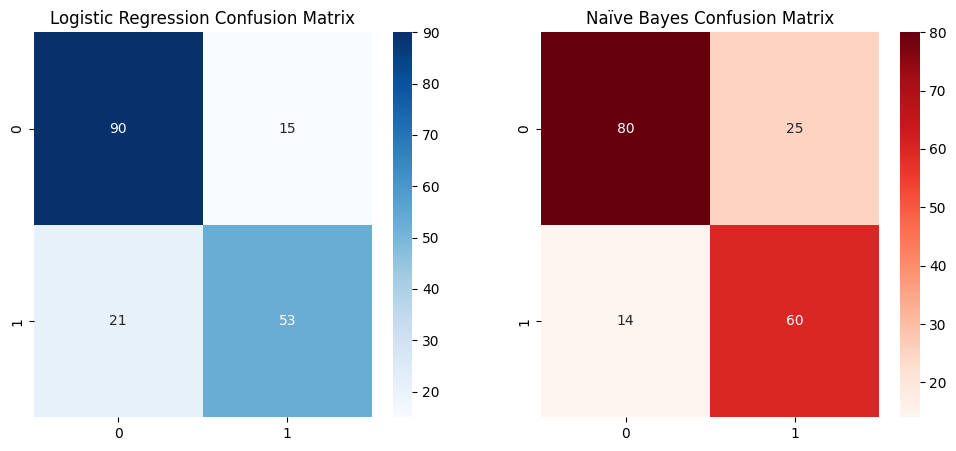

In [ ]:
conf_matrix_log = confusion_matrix(y_test, y_pred_log) # confusion_matrix для результатов логистической регрессии
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb) # для результатов байесовского классификатора

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Naïve Bayes Confusion Matrix")

plt.show()